In [ ]:
%pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import contractions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Data Loading

### Dataset Overview

In [ ]:
dataset_path = '/content/drive/MyDrive/CS 412/Project/IMDB Dataset.csv'
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


A positive sample from dataset.

In [ ]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

A negative sample from dataset.

In [ ]:
df['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

*   The dataset is balanced, 25k positive and 25k negative samples.
*   We have no NA values, which is good.
*   There are 418 duplicate data points.

In [ ]:
print(f"Dataset shape: {df.shape}\n")
print(f"Class distribution:\n{df['sentiment'].value_counts()}\n")
print(f"Missing values:\n{df.isnull().sum()}\n")
print(f"Duplicate reviews: {df.duplicated().sum()}")

Dataset shape: (50000, 2)

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing values:
review       0
sentiment    0
dtype: int64

Duplicate reviews: 418


### Length Analysis

In [ ]:
# analysis of length of the reviews
df['review_length_chars'] = df['review'].apply(len)
df['review_length_words'] = df['review'].apply(lambda x: len(x.split()))

print(f"Average review length (characters): {df['review_length_chars'].mean():.2f}\n")
print(f"Average review length (words): {df['review_length_words'].mean():.2f}\n")
print(f"Minimum review length (words): {df['review_length_words'].min()}\n")
print(f"Maximum review length (words): {df['review_length_words'].max()}")

Average review length (characters): 1309.43

Average review length (words): 231.16

Minimum review length (words): 4

Maximum review length (words): 2470


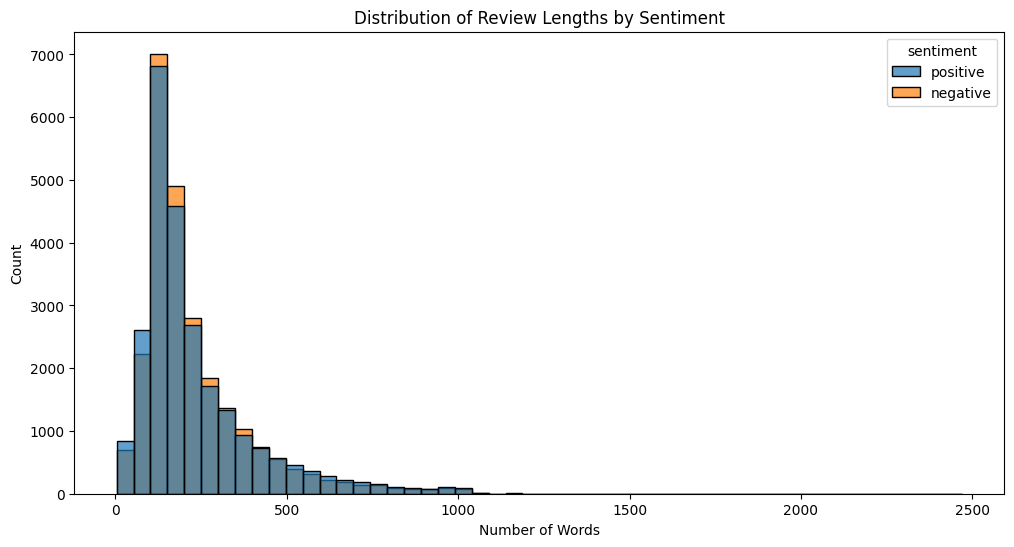

In [ ]:
# review length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length_words', hue='sentiment', bins=50, alpha=0.7)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.savefig('review_length_distribution.png')
plt.show()

### Vocabulary Analysis

In [ ]:
# function to extract all words from reviews
def get_words(reviews):
    words = []
    for review in reviews:
        words.extend(word_tokenize(review.lower()))
    return words

In [ ]:
# get all the words
all_words = get_words(df['review'])
positive_words = get_words(df[df['sentiment'] == 'positive']['review'])
negative_words = get_words(df[df['sentiment'] == 'negative']['review'])

In [ ]:
# vocab size
vocab = set(all_words)
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 164024


Here, 'br' is an HTML tag and it will definetly be removed in the preprocessing section.

In [ ]:
# most common words (except stopwords)
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word.isalpha() and word not in stop_words]
most_common = Counter(filtered_words).most_common(20)
print("Most common words:")
for word, count in most_common:
    print(f"{word}: {count}")

Most common words:
br: 201951
movie: 85070
film: 76919
one: 51828
like: 39183
good: 28767
would: 26475
even: 24780
time: 23481
really: 23024
see: 22638
story: 22341
well: 19041
much: 19020
could: 18518
get: 18264
people: 17962
great: 17918
also: 17873
bad: 17837


In [ ]:
# generate word clouds for positive and negative reviews
positive_text = ' '.join([review for review in df[df['sentiment'] == 'positive']['review']])
negative_text = ' '.join([review for review in df[df['sentiment'] == 'negative']['review']])

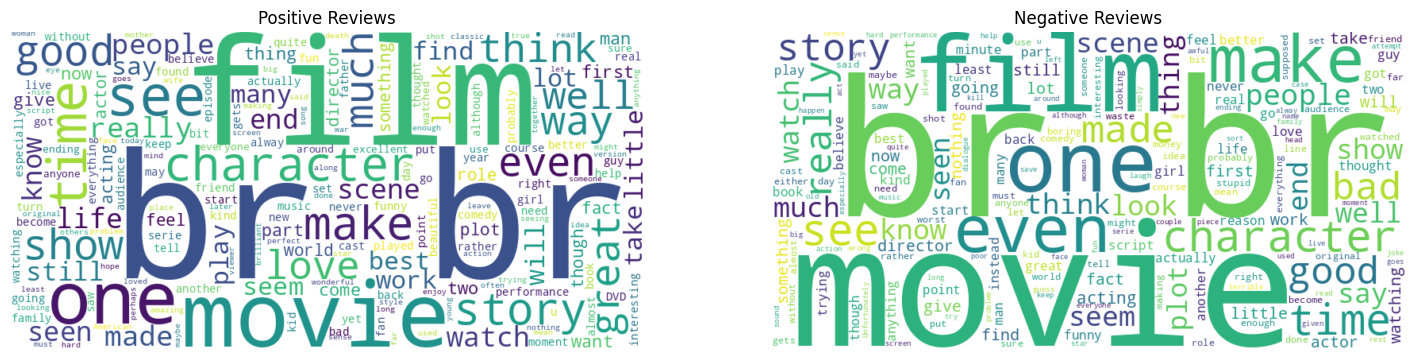

In [ ]:
plt.figure(figsize=(18, 10))

# positive word cloud
plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

# negative word cloud
plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')
plt.savefig('sentiment_wordclouds.png')

# display
plt.show()

## Data Preprocessing

### Dropping the Duplicates

In [ ]:
# Count how many duplicate reviews there are
num_dupes = df['review'].duplicated().sum()
print(f"Number of duplicate reviews: {num_dupes}")

# Drop duplicates and reset index
df = df.drop_duplicates(subset='review').reset_index(drop=True)
print(f"New DataFrame shape: {df.shape}")  # (rows, columns)

Number of duplicate reviews: 418
New DataFrame shape: (49582, 4)


### Text cleaning (Clean the HTML Tags, Expand Contractions etc.)

In [ ]:
def clean_text(text: str) -> str:
    # 1) Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # 2) Expand contractions (e.g., "won't" → "will not")
    text = contractions.fix(text)
    # 3) Convert to lowercase
    text = text.lower()
    # 4) Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)
    # 5) Collapse multiple spaces into one
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Apply cleaning function
df['cleaned_review'] = df['review'].apply(clean_text)
print(df[['review', 'cleaned_review']].head(3))

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti...  


### Tokenize

In [ ]:
# Tokenize each cleaned review
df['tokens'] = df['cleaned_review'].apply(word_tokenize)
print(df['tokens'].head(3))

0    [one, of, the, other, reviewers, has, mentione...
1    [a, wonderful, little, production, the, filmin...
2    [i, thought, this, was, a, wonderful, way, to,...
Name: tokens, dtype: object


### Remove Stop Words

In [ ]:
stop_words = set(stopwords.words('english'))

# Filter out stop-words from token lists
df['tokens_nostop'] = df['tokens'].apply(
    lambda toks: [t for t in toks if t not in stop_words]
)
print(df['tokens_nostop'].head(3))

0    [one, reviewers, mentioned, watching, oz, epis...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
Name: tokens_nostop, dtype: object


### Lemmetize

In [ ]:
lemmatizer = WordNetLemmatizer()

df['tokens_lemmatized'] = df['tokens_nostop'].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)
print(df['tokens_lemmatized'].head(3))

0    [one, reviewer, mentioned, watching, oz, episo...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
Name: tokens_lemmatized, dtype: object


### Rejoin the Tokens

In [ ]:
# Rejoin tokens into a single string per document
df['processed_review'] = df['tokens_lemmatized'].apply(lambda toks: ' '.join(toks))

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=10_000,
    ngram_range=(1, 2)
)

# Fit-transform on processed text
X_tfidf = tfidf.fit_transform(df['processed_review'])
print(f"TF-IDF matrix shape: {X_tfidf.shape}")

TF-IDF matrix shape: (49582, 10000)


### Data Splitting

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# First split: 70% train, 30% temp
X_train_tfidf, X_temp, y_train, y_temp = train_test_split(
    X_tfidf,
    df['sentiment'],
    test_size=0.30,
    random_state=SEED,
    stratify=df['sentiment']
)

# Second split: split the 30% temp into 15% val and 15% test (i.e. half of temp each)
X_val_tfidf, X_test_tfidf, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=SEED,
    stratify=y_temp
)

# Print out the resulting shapes
print(f"X_train_tfidf: {X_train_tfidf.shape}")
print(f"X_val_tfidf:   {X_val_tfidf.shape}")
print(f"X_test_tfidf:  {X_test_tfidf.shape}")
print(f"y_train:       {y_train.shape}")
print(f"y_val:         {y_val.shape}")
print(f"y_test:        {y_test.shape}")

X_train_tfidf: (34707, 10000)
X_val_tfidf:   (7437, 10000)
X_test_tfidf:  (7438, 10000)
y_train:       (34707,)
y_val:         (7437,)
y_test:        (7438,)


## Training and Evaluation

### Hyperparameter Optimization

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best alpha: 1.00

-- Validation Metrics --
Accuracy:  0.8672
Precision: 0.8676
Recall:    0.8671
F1 Score:  0.8671
ROC-AUC:   0.9399


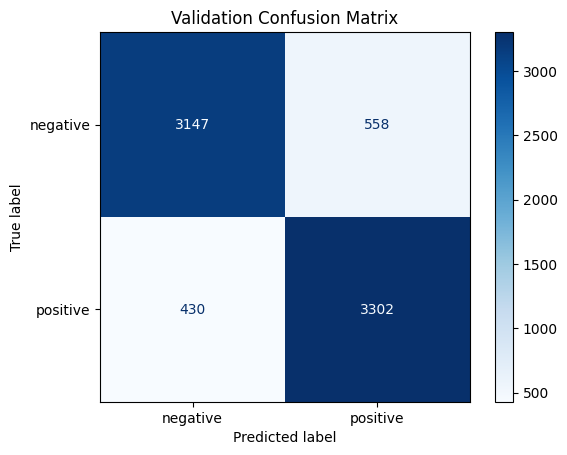


-- Test Metrics --
Accuracy:  0.8686
Precision: 0.8691
Recall:    0.8686
F1 Score:  0.8686
ROC-AUC:   0.9384


In [ ]:
# 1) Hyperparameter Optimization + ROC-AUC + Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# 1.1) Use GridSearchCV to find the best alpha value
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0]}
grid = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train_tfidf, y_train)

best_alpha = grid.best_params_['alpha']
print(f"Best alpha: {best_alpha:.2f}")

# 1.2) Evaluate the best model on the validation set
best_nb = grid.best_estimator_

y_val_pred = best_nb.predict(X_val_tfidf)
y_val_proba = best_nb.predict_proba(X_val_tfidf)[:, 1]  # probabilities for the positive class

print("\n-- Validation Metrics --")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_val_pred, average='macro'):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val.map({'negative':0,'positive':1}), y_val_proba):.4f}")

# 1.3) Plot the confusion matrix for the validation set
cm = confusion_matrix(y_val, y_val_pred, labels=['negative','positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

# 1.4) Evaluate on the test set
y_test_pred = best_nb.predict(X_test_tfidf)
y_test_proba = best_nb.predict_proba(X_test_tfidf)[:, 1]

print("\n-- Test Metrics --")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred, average='macro'):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test.map({'negative':0,'positive':1}), y_test_proba):.4f}")


### K-Fold Cross Validation

In [ ]:
# 2) Stratified K-Fold Cross-Validation for Performance Estimation

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 2.1) Set up StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
alpha_value = best_alpha  # use the best alpha found above
fold_metrics = []

# 2.2) Loop through each fold: train on train split, evaluate on validation split
for fold, (train_idx, val_idx) in enumerate(skf.split(X_tfidf, df['sentiment']), start=1):
    X_tr, X_va = X_tfidf[train_idx], X_tfidf[val_idx]
    y_tr, y_va = df['sentiment'].iloc[train_idx], df['sentiment'].iloc[val_idx]

    model = MultinomialNB(alpha=alpha_value)
    model.fit(X_tr, y_tr)

    y_va_pred = model.predict(X_va)

    fold_metrics.append({
        'fold': fold,
        'accuracy': accuracy_score(y_va, y_va_pred),
        'precision': precision_score(y_va, y_va_pred, average='macro'),
        'recall': recall_score(y_va, y_va_pred, average='macro'),
        'f1_score': f1_score(y_va, y_va_pred, average='macro'),
    })

# 2.3) Display per-fold metrics and the average macro-F1
metrics_df = pd.DataFrame(fold_metrics)
print(metrics_df)
print("\nAverage Macro-F1 across 5 folds: "
      f"{metrics_df['f1_score'].mean():.4f}")


   fold  accuracy  precision    recall  f1_score
0     1  0.862458   0.862861  0.862396  0.862404
1     2  0.869214   0.869546  0.869159  0.869171
2     3  0.871218   0.871618  0.871156  0.871168
3     4  0.865268   0.865628  0.865208  0.865220
4     5  0.867285   0.867592  0.867233  0.867244

Average Macro-F1 across 5 folds: 0.8670
